**временные ряды и модели ARIMA**

Евгений Борисов <esborisov@sevsu.ru>

-----

Дмитрий Макаров   Временные ряды.    
https://www.dmitrymakarov.ru/intro/time-series-20/

Евгений Рябенко Прогнозирование временных рядов.     
https://www.youtube.com/watch?v=u433nrxdf5k

-----

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt
import pandas as pd
#from tqdm.auto import tqdm
#tqdm.pandas()
np.set_printoptions(precision=2)

---

AirPassengers.csv

https://drive.google.com/file/d/1yfw6gcgmJXCtxkjC69ekUvsEtAiYTlST/view?usp=share_link

https://huggingface.co/spaces/Anniek/Time_series_forecast/raw/main/AirPassengers.csv

In [2]:
# читаем данные
url = 'https://huggingface.co/spaces/Anniek/Time_series_forecast/raw/main/AirPassengers.csv'
df = pd.read_csv(url).convert_dtypes()
display(len(df))
display(df.info())
display(df.describe().T)

144

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    string
 1   #Passengers  144 non-null    Int64 
dtypes: Int64(1), string(1)
memory usage: 2.5 KB


None

,count,mean,std,min,25%,50%,75%,max
#Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [3]:
df['dt'] = pd.to_datetime(df['Month'])
df = df.set_index('dt')
df = df[['#Passengers']]

display(df.sample(3))

,#Passengers
dt,
1959-09-01,463
1955-09-01,312
1955-12-01,278


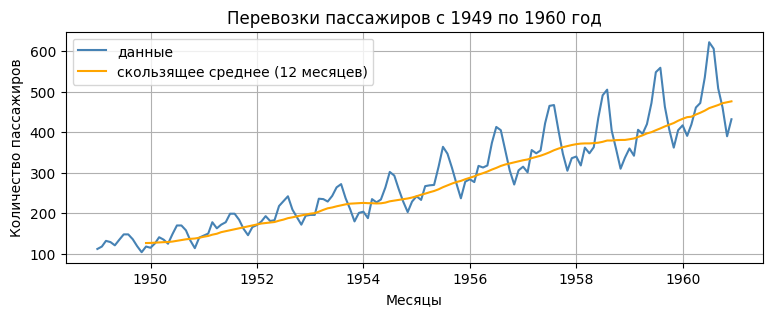

In [4]:
fig,ax = plt.subplots(figsize = (9,3))
ax.plot(df['#Passengers'], label = 'данные', color = 'steelblue')
ax.plot(df['#Passengers'].rolling(window=12).mean(), label = 'скользящее среднее (12 месяцев)', color = 'orange')
ax.set_xlabel('Месяцы', )
ax.set_ylabel('Количество пассажиров',)
ax.set_title('Перевозки пассажиров с 1949 по 1960 год', )
ax.legend(title = '', loc = 'upper left', )
ax.grid()

# простая регрессия

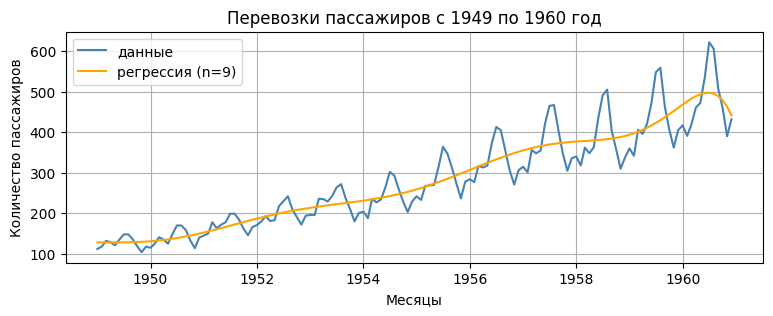

In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

t = df['#Passengers'].values

degree = 9
x =  PolynomialFeatures( 
        degree=degree, 
        interaction_only=False, 
        include_bias=True,
    ).fit_transform( np.arange(len(t)).reshape(-1,1) )
    
df['regr'] = LinearRegression().fit(x,t).predict(x)

fig,ax = plt.subplots(figsize = (9,3))
ax.plot(df['#Passengers'], label = 'данные', color = 'steelblue')
ax.plot(df['regr'], label = f'регрессия (n={degree})', color = 'orange')
ax.set_xlabel('Месяцы', )
ax.set_ylabel('Количество пассажиров',)
ax.set_title('Перевозки пассажиров с 1949 по 1960 год', )
ax.legend(title = '', loc = 'upper left', )
ax.grid()

# анализ данных

In [6]:
# !pip install statsmodels

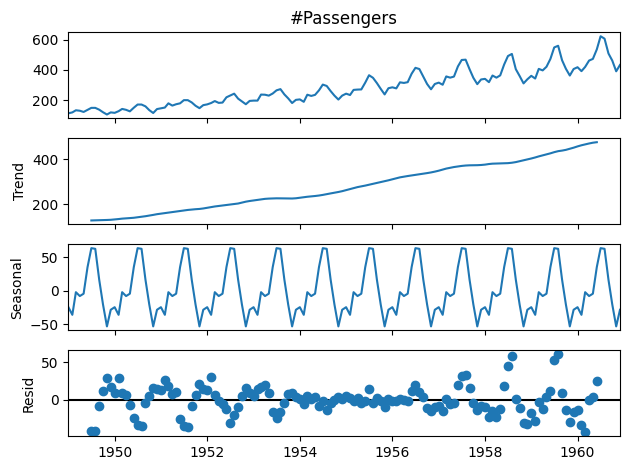

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(df['#Passengers'])
decompose.plot()
plt.show()

#### Проверка временного ряда на стационарность

In [13]:
# тест Дики-Фуллера (Dickey-Fuller test)

from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df['#Passengers'])

print('p-value = ' + str(adf_test[1]))

p-value = 0.991880243437641


#### Автокорреляция

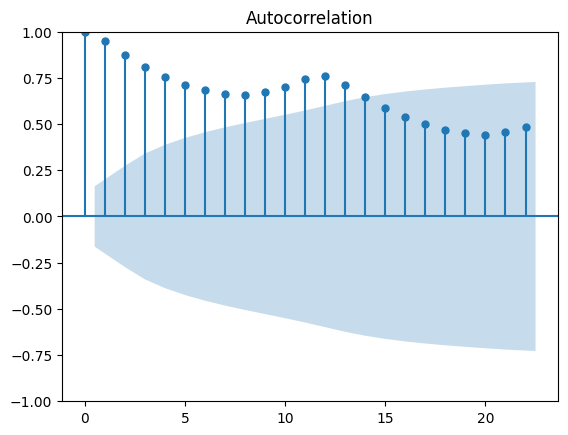

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['#Passengers'])
plt.show()

# стабилизация дисперсии

In [9]:
from scipy.stats import boxcox

df['bc'] = boxcox(df['#Passengers'])[0]

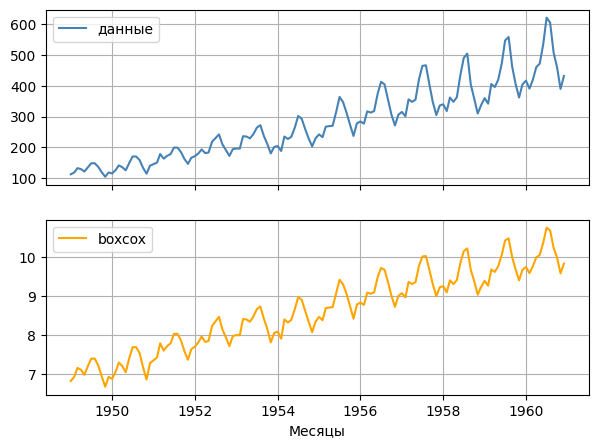

In [20]:
fig,ax = plt.subplots(2,1, figsize = (7,5),sharex=True)
ax[0].plot(df['#Passengers'], label = 'данные', color = 'steelblue')
#ax[0].set_xlabel('Месяцы', )
#ax[0].set_ylabel('Количество пассажиров',)
#ax[0].set_title('Перевозки пассажиров с 1949 по 1960 год', )
ax[0].legend(title = '', loc = 'upper left', )
ax[0].grid()

ax[1].plot(df['bc'], label = 'boxcox', color = 'orange')
ax[1].set_xlabel('Месяцы', )
#ax[1].set_ylabel('Количество пассажиров',)
#ax[0].set_title('Перевозки пассажиров с 1949 по 1960 год', )
ax[1].legend(title = '', loc = 'upper left', )
ax[1].grid()

# стабилизация тренда

In [22]:
df['dif1'] = df['bc'].diff()

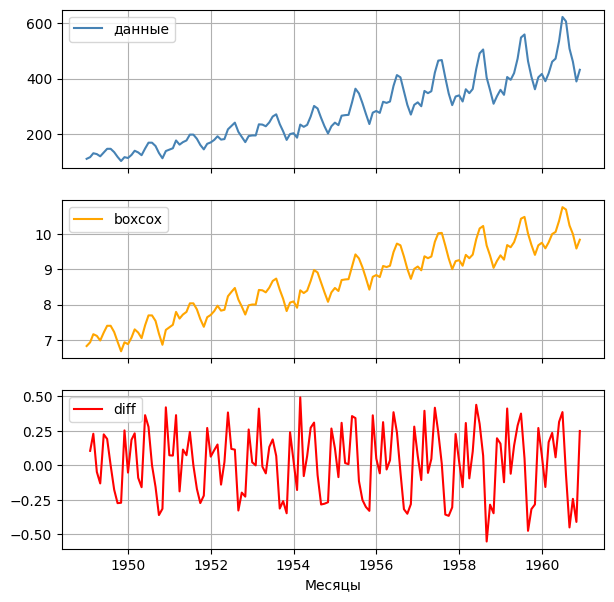

In [25]:
fig,ax = plt.subplots(3,1, figsize = (7,7),sharex=True)
ax[0].plot(df['#Passengers'], label = 'данные', color = 'steelblue')
#ax[0].set_xlabel('Месяцы', )
#ax[0].set_ylabel('Количество пассажиров',)
#ax[0].set_title('Перевозки пассажиров с 1949 по 1960 год', )
ax[0].legend(title = '', loc = 'upper left', )
ax[0].grid()

ax[1].plot(df['bc'], label = 'boxcox', color = 'orange')
ax[1].legend(title = '', loc = 'upper left', )
ax[1].grid()

ax[2].plot(df['dif1'], label = 'diff', color = 'red')
ax[2].set_xlabel('Месяцы', )
ax[2].legend(title = '', loc = 'upper left', )
ax[2].grid()

# модель

In [23]:
# разобьём данные на обучающую и тестовую выборки

# обучающая выборка будет включать данные до декабря 1959 года включительно
train = df[:'1959-12']['#Passengers']

# тестовая выборка начнется с января 1960 года (по сути, один год)
test = df['1960-01':]['#Passengers']

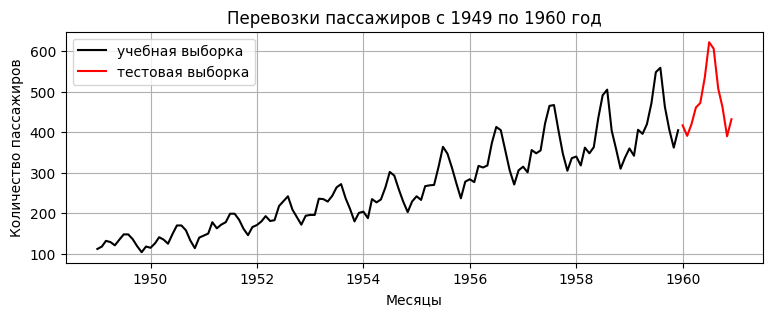

In [24]:
fig,ax = plt.subplots(figsize = (9,3))
ax.plot(train, color = 'black',label='учебная выборка')
ax.plot(test, color = 'red',label='тестовая выборка')

ax.set_xlabel('Месяцы', )
ax.set_ylabel('Количество пассажиров',)
ax.set_title('Перевозки пассажиров с 1949 по 1960 год', )
ax.legend(title = '', loc = 'upper left', )
ax.grid()

In [25]:
# обучим модель с соответствующими параметрами, SARIMAX(3, 0, 0)x(0, 1, 0, 12)
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
        np.array(train,dtype=int).flatten(), 
        order = (3, 0, 0), 
        seasonal_order = (0, 1, 0, 12)
    ).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42479D+00    |proj g|=  3.63776D-03

At iterate    5    f=  3.42452D+00    |proj g|=  8.58521D-03

At iterate   10    f=  3.42416D+00    |proj g|=  9.72822D-03

At iterate   15    f=  3.42389D+00    |proj g|=  4.95506D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     18      1     0     0   4.955D-06   3.424D+00
  F =   3.4238882841138847     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [26]:
# мы можем посмотреть результат с помощью метода summary()
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(3, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -451.953
Date:                            Tue, 23 Apr 2024   AIC                            911.907
Time:                                    12:44:05   BIC                            923.056
Sample:                                         0   HQIC                           916.435
                                            - 132                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7603      0.088      8.672      0.000       0.588       0.932
ar.L2          0.2875      0.133   

# тестируем

In [28]:
start,end  = len(train), len(train)+len(test)-1
predicticted = model.predict(start, end)
predicticted = pd.DataFrame(predicticted,index=test.index,columns=['predicticted']) 

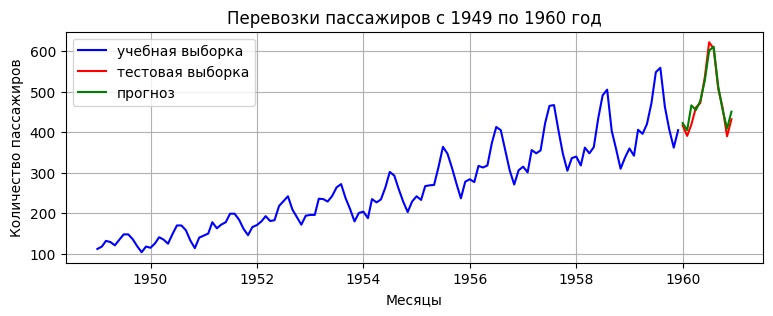

In [31]:
fig,ax = plt.subplots(figsize = (9,3))
ax.plot(train, color = 'blue',label='учебная выборка')
ax.plot(test, color = 'red',label='тестовая выборка')
ax.plot(predicticted, color = 'green',  label='прогноз')

ax.set_xlabel('Месяцы', )
ax.set_ylabel('Количество пассажиров',)
ax.set_title('Перевозки пассажиров с 1949 по 1960 год', )
ax.legend(title = '', loc = 'upper left', )
ax.grid()

In [33]:
# from sklearn.metrics import mean_squared_error
# print(mean_squared_error(test, predictions))
# print(np.sqrt(mean_squared_error(test, predictions)))

---

In [38]:
# построим прогноз на три года вперед
start, end = len(train), (len(df)-1)+3*12
predicticted = model.predict(start, end)

predicticted= pd.DataFrame(
    predicticted[-12:],
    index=pd.to_datetime( [ f'1963-{n}-01' for n in range(1,13) ] ),
    columns = ['forecast']
)

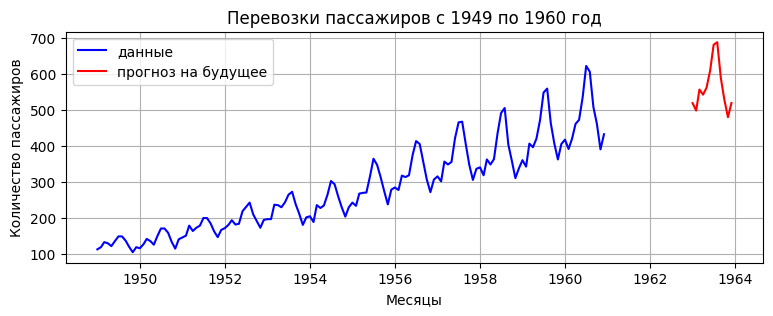

In [39]:
fig,ax = plt.subplots(figsize = (9,3))
ax.plot(df['#Passengers'], color = 'blue',label='данные')
ax.plot(predicticted, color = 'red',label='прогноз на будущее')
ax.set_xlabel('Месяцы', )
ax.set_ylabel('Количество пассажиров',)
ax.set_title('Перевозки пассажиров с 1949 по 1960 год', )
ax.legend(title = '', loc = 'upper left', )
ax.grid()